# 1. Build a basic chatbot

In this tutorial, you will build a basic chatbot. This chatbot is the basis for the following series of tutorials where you will progressively add more sophisticated capabilities, and be introduced to key LangGraph concepts along the way. Let's dive in! 🌟

## Prerequisites

Before you start this tutorial, ensure you have access to a LLM that supports
tool-calling features, such as [OpenAI](https://platform.openai.com/api-keys),
[Anthropic](https://console.anthropic.com/settings/keys), or
[Google Gemini](https://ai.google.dev/gemini-api/docs/api-key).

## 1. Install packages

Install the required packages:

In [1]:
# pip install -U langgraph langsmith

Sign up for LangSmith to quickly spot issues and improve the performance of your LangGraph projects. LangSmith lets you use trace data to debug, test, and monitor your LLM apps built with LangGraph. For more information on how to get started, see [LangSmith docs](https://docs.smith.langchain.com).


## 2. Create a `StateGraph`

Now you can create a basic chatbot using LangGraph. This chatbot will respond directly to user messages.

Start by creating a `StateGraph`. A `StateGraph` object defines the structure of our chatbot as a "state machine". We'll add `nodes` to represent the llm and functions our chatbot can call and `edges` to specify how the bot should transition between these functions.

In [2]:
from typing import Annotated

from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages


class State(TypedDict):
    # Messages have the type "list". The `add_messages` function
    # in the annotation defines how this state key should be updated
    # (in this case, it appends messages to the list, rather than overwriting them)
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)

Our graph can now handle two key tasks:

1. Each `node` can receive the current `State` as input and output an update to the state.
2. Updates to `messages` will be appended to the existing list rather than overwriting it, thanks to the prebuilt reducer function.

**Concept**
When defining a graph, the first step is to define its `State`. The `State` includes the graph's schema and [reducer functions](/oss/graph-api#reducers) that handle state updates. In our example, `State` is a schema with one key: `messages`. The reducer function is used to append new messages to the list instead of overwriting it. Keys without a reducer annotation will overwrite previous values.
  
To learn more about state, reducers, and related concepts, see [LangGraph reference docs](https://langchain-ai.github.io/langgraph/reference/graphs/#langgraph.graph.message.add_messages).

## 3. Add a node

Next, add a "`chatbot`" node. **Nodes** represent units of work and are typically regular functions.

Let's first select a chat model:

In [3]:
# pip install -U "langchain[openai]"

In [4]:
import os
import getpass
from langchain.chat_models import init_chat_model

# Function to securely get OpenAI API key
def get_openai_api_key():
    """Securely prompt user for OpenAI API key"""
    # First try to get from environment variable
    api_key = os.environ.get("OPENAI_API_KEY")
    
    if not api_key:
        print("OpenAI API key not found in environment variables.")
        print("Please enter your OpenAI API key:")
        print("Note: Your input will be hidden for security.")
        api_key = getpass.getpass("OpenAI API Key: ")
        
        if api_key:
            # Set it for this session only
            os.environ["OPENAI_API_KEY"] = api_key
            print("API key set for this session.")
        else:
            raise ValueError("OpenAI API key is required to run this chatbot.")
    
    return api_key

# Get the API key securely
api_key = get_openai_api_key()

# Initialize the chat model
llm = init_chat_model("openai:gpt-4.1")

We can now incorporate the chat model into a simple node:

In [5]:
def chatbot(state: State):
    return {"messages": [llm.invoke(state["messages"])]}


# The first argument is the unique node name
# The second argument is the function or object that will be called whenever
# the node is used.
graph_builder.add_node("chatbot", chatbot)

**Notice** how the `chatbot` node function takes the current `State` as input and returns a dictionary containing an updated `messages` list under the key "messages". This is the basic pattern for all LangGraph node functions.

The `add_messages` function in our `State` will append the LLM's response messages to whatever messages are already in the state.

## 4. Add an `entry` point

Add an `entry` point to tell the graph **where to start its work** each time it is run:

In [6]:
graph_builder.add_edge(START, "chatbot")

## 5. Add an `exit` point

Add an `exit` point to indicate **where the graph should finish execution**. This is helpful for more complex flows, but even in a simple graph like this, adding an end node improves clarity.

In [7]:
graph_builder.add_edge("chatbot", END)

This tells the graph to terminate after running the chatbot node.

## 6. Compile the graph

Before running the graph, we'll need to compile it. We can do so by calling `compile()`
on the graph builder. This creates a `CompiledGraph` we can invoke on our state.

In [8]:
graph = graph_builder.compile()

## 7. Visualize the graph

You can visualize the graph using the `get_graph` method and one of the "draw" methods, like `draw_ascii` or `draw_png`. The `draw` methods each require additional dependencies.

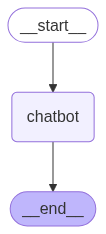

In [9]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

## 8. Run the chatbot

Now run the chatbot!

You can exit the chat loop at any time by typing `quit`, `exit`, or `q`.

In [10]:
def stream_graph_updates(user_input: str):
    for event in graph.stream({"messages": [{"role": "user", "content": user_input}]}):
        for value in event.values():
            print("Assistant:", value["messages"][-1].content)


while True:
    try:
        user_input = input("User: ")
        if user_input.lower() in ["quit", "exit", "q"]:
            print("Goodbye!")
            break
        stream_graph_updates(user_input)
    except:
        # fallback if input() is not available
        user_input = "What do you know about LangGraph?"
        print("User: " + user_input)
        stream_graph_updates(user_input)
        break

Assistant: **LangGraph** is an open-source framework designed to build stateful, multi-agent applications using Large Language Models (LLMs). It is created by the same team behind **LangChain**, a popular library for composing LLM applications.

Here’s what you should know about LangGraph:

---

## What does LangGraph do?

- **Graphs for LLM Workflows:** LangGraph enables you to design complex application "flows" using **graphs**. In these, nodes typically represent agents, tools, or function calls, and edges define how information passes between components.
- **Stateful and Recurrent:** It handles applications where the output of one step informs the next, supporting loops, memory, and multi-turn agent conversations.
- **Multi-Agent Systems:** LangGraph shines in situations where multiple agents (LLM-based or otherwise) interact, collaborate, or debate to solve a problem.
- **Interoperability with LangChain:** LangGraph is built to work nicely with LangChain components (tools, memory,